In [1]:
import xgboost as xgb
import gc
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Train XGBoost with GPU acceleration on full features
print("Training XGBoost model on full feature set...")

# Load training data
print("Loading training data...")
train_data = pd.read_csv('split_data/train_data.csv')
X_train = train_data.drop(['Header', 'Position', 'target'], axis=1)
y_train = train_data['target']
del train_data
gc.collect()

# Load validation data
print("Loading validation data...")
val_data = pd.read_csv('split_data/val_data.csv')
X_val = val_data.drop(['Header', 'Position', 'target'], axis=1)
y_val = val_data['target']
del val_data
gc.collect()

# Convert to DMatrix (XGBoost's optimized data structure)
print("Converting to DMatrix...")
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Free up more memory
del X_train, y_train, X_val, y_val
gc.collect()

Training XGBoost model on full feature set...
Loading training data...
Loading validation data...
Converting to DMatrix...


7

In [3]:
import numpy as np

# Retrieve the training labels from dtrain
retrieved_y_train = dtrain.get_label()

# Compute and print the target distribution
unique_labels, counts = np.unique(retrieved_y_train, return_counts=True)
print("Training set target distribution:")
print(dict(zip(unique_labels, counts)))

Training set target distribution:
{0.0: 18628, 1.0: 18644}


In [4]:
# Retrieve the validation labels from dval
retrieved_y_val = dval.get_label()

# Compute and print the target distribution
unique_labels_val, counts_val = np.unique(retrieved_y_val, return_counts=True)
print("Validation set target distribution:")
print(dict(zip(unique_labels_val, counts_val)))

Validation set target distribution:
{0.0: 6210, 1.0: 6214}


In [2]:
# Set parameters (with GPU acceleration)
params = {
    'objective': 'binary:logistic',
    'eval_metric': ['logloss', 'auc'],
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'device': 'cuda',
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # Use GPU acceleration
    'max_bin': 256  # For GPU, this can speed up training
}

evals_result = {}

# Train the model
print("Training model...")
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=50,
    evals_result=evals_result,   # <--- ADD THIS
    verbose_eval=50
)

Training model...
[0]	train-logloss:0.67097	train-auc:0.77270	validation-logloss:0.67160	validation-auc:0.76461
[50]	train-logloss:0.47797	train-auc:0.86218	validation-logloss:0.51073	validation-auc:0.83144
[100]	train-logloss:0.44601	train-auc:0.88458	validation-logloss:0.50079	validation-auc:0.83691
[150]	train-logloss:0.42937	train-auc:0.89670	validation-logloss:0.49773	validation-auc:0.83890
[200]	train-logloss:0.41400	train-auc:0.90711	validation-logloss:0.49518	validation-auc:0.84030
[250]	train-logloss:0.40319	train-auc:0.91438	validation-logloss:0.49393	validation-auc:0.84100
[300]	train-logloss:0.39192	train-auc:0.92189	validation-logloss:0.49269	validation-auc:0.84180
[350]	train-logloss:0.38184	train-auc:0.92803	validation-logloss:0.49171	validation-auc:0.84223
[400]	train-logloss:0.37165	train-auc:0.93377	validation-logloss:0.49026	validation-auc:0.84326
[450]	train-logloss:0.36368	train-auc:0.93859	validation-logloss:0.49011	validation-auc:0.84340
[500]	train-logloss:0.354

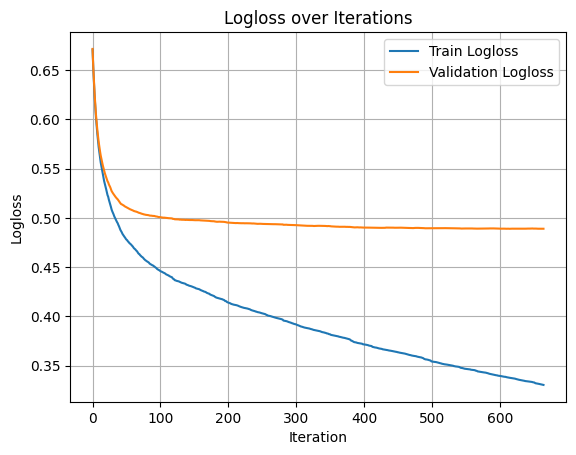

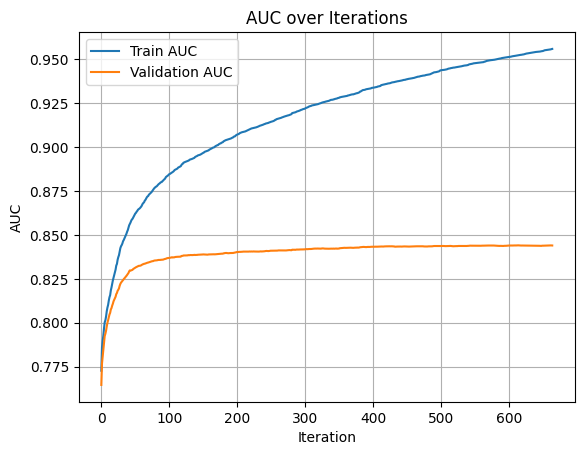

In [4]:
import matplotlib.pyplot as plt

# Plot logloss
plt.plot(evals_result['train']['logloss'], label='Train Logloss')
plt.plot(evals_result['validation']['logloss'], label='Validation Logloss')
plt.title('Logloss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.legend()
plt.grid(True)
plt.show()

# Plot AUC
plt.plot(evals_result['train']['auc'], label='Train AUC')
plt.plot(evals_result['validation']['auc'], label='Validation AUC')
plt.title('AUC over Iterations')
plt.xlabel('Iteration')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# Save the model
model.save_model('phosphorylation_xgb_model.json')
print("Model saved to phosphorylation_xgb_model.json")

# Free memory
# del dtrain, dval
gc.collect()

# Evaluate on test set
print("Evaluating on test set...")
test_data = pd.read_csv('split_data/test_data.csv')
X_test = test_data.drop(['Header', 'Position', 'target'], axis=1)
y_test = test_data['target']

# Create DMatrix for test data
dtest = xgb.DMatrix(X_test)

# Make predictions
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Test Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

# Save the results
results = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1": f1,
    "ROC_AUC": roc_auc,
    "Confusion_Matrix": conf_matrix.tolist()
}

import json
with open('model_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Results saved to model_results.json")

Model saved to phosphorylation_xgb_model.json
Evaluating on test set...
Test Metrics:
Accuracy: 0.7592
Precision: 0.7533
Recall: 0.7710
F1 Score: 0.7621
ROC AUC: 0.8404
Confusion Matrix:
[[4640 1569]
 [1423 4792]]
Results saved to model_results.json


### 📊 **Model (XGboost) Evaluation Summary**

1. **Accuracy**: **75.92%**  
   - Overall, the model correctly predicted about 76% of the test samples.

2. **Precision** (Positive Predictive Value): **75.33%**  
   - Of all the samples the model predicted as positive, ~75% were actually positive.  
   - Indicates how *reliable* positive predictions are.

3. **Recall** (Sensitivity / True Positive Rate): **77.10%**  
   - The model correctly identified ~77% of all actual positive cases.  
   - Reflects how well it detects positives.

4. **F1 Score**: **76.21%**  
   - Harmonic mean of precision and recall — a balanced measure when both false positives and false negatives matter.

5. **ROC AUC**: **0.8404**  
   - AUC of 0.84 indicates strong ability to distinguish between classes.  
   - Closer to 1 = better; 0.5 = random guessing.

6. **Confusion Matrix**:
   ```
   True Negatives (TN): 4640  
   False Positives (FP): 1569  
   False Negatives (FN): 1423  
   True Positives (TP): 4792
   ```

7. **Sensitivity (Recall)**: **77.10%**  
   - Already given as recall — ability to correctly detect actual positives.

8. **Specificity (True Negative Rate)**:
   - The model correctly identified ~74.7% of actual negatives.

### 🧠 Interpretation:

- The model performs **balanced classification**, with decent sensitivity and specificity.
- It’s slightly **better at detecting positives (77.1%)** than negatives (74.7%).
- The **AUC of 0.84** suggests the model has good discriminative power.
- Could be tuned further depending on whether **false positives** or **false negatives** are more costly in your case (e.g., medical diagnoses, fraud detection, etc.).

---

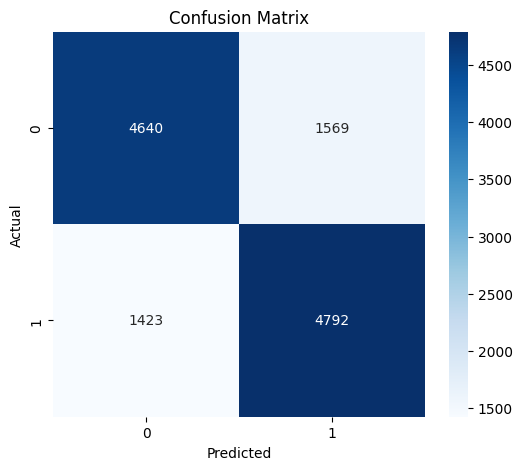

In [6]:
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

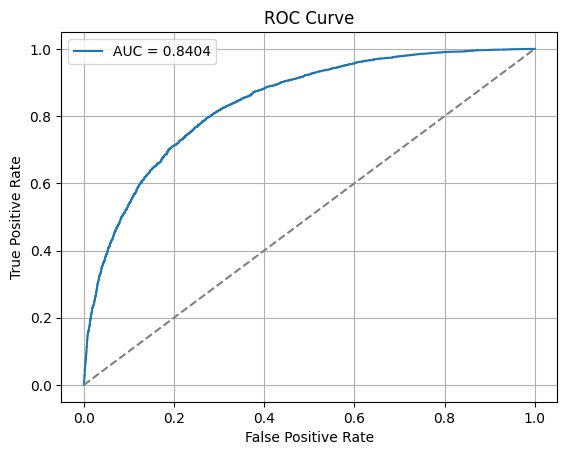

In [7]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

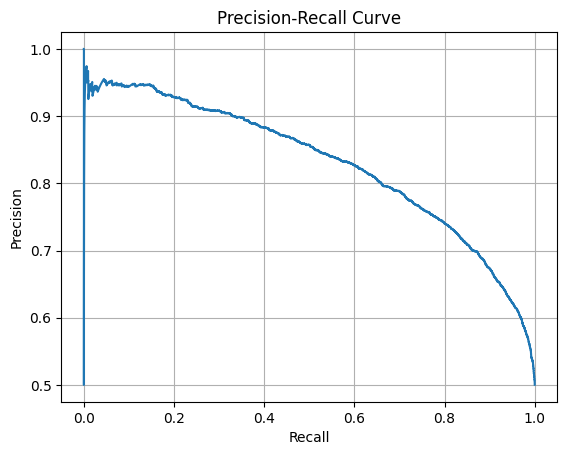

In [9]:
from sklearn.metrics import precision_recall_curve

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(recall_vals, precision_vals)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [13]:
# Get feature importances based on gain
importance_dict = model.get_score(importance_type='gain')

# Sort by importance (descending)
sorted_importance = dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))

# Pretty print
for feature, score in sorted_importance.items():
    print(f"{feature}: {score:.4f}")

PC_83: 420.6534
BE_133: 178.8413
PC_81: 166.6864
TP: 79.4717
YP: 75.7543
W: 54.0860
PC_82: 43.2460
PC_46: 38.3808
C: 37.0512
PC_106: 35.1564
Y: 33.8404
SP: 32.2068
BE_164: 31.3228
PC_111: 30.6086
PC_127: 28.3514
PC_47: 22.5992
PC_48: 22.4959
BE_56: 21.3682
PC_34: 20.0398
NNN: 18.3307
PC_143: 17.4965
PC_137: 17.0881
D: 16.1863
PC_108: 15.0127
PC_33: 14.9575
PC_112: 14.9407
S: 14.8564
PC_139: 14.7358
BE_72: 13.7247
R: 13.7188
BE_196: 13.3957
K: 13.3603
SVD: 13.1341
BE_10: 12.5897
YGS: 12.4678
GD: 12.2754
SSG: 12.2170
SRY: 12.2113
SNL: 11.7730
DE: 11.5083
RI: 11.4684
PC_141: 11.4179
SNT: 11.4071
BE_156: 11.3216
SS: 11.1037
SI: 11.0965
DD: 11.0839
DP: 11.0299
YSN: 10.9693
QK: 10.9049
RTT: 10.8507
KAG: 10.7926
LF: 10.7040
PC_105: 10.6543
VD: 10.6041
YV: 10.5993
KLS: 10.5520
DNS: 10.5013
BE_47: 10.4856
GGT: 10.4512
SSA: 10.4143
SEP: 10.4103
FP: 10.2874
FL: 10.2029
PC_116: 10.1279
PC_144: 9.9985
GGS: 9.9504
TDE: 9.9479
RN: 9.8567
PC_110: 9.8373
DV: 9.6778
LES: 9.6053
FG: 9.6020
KS: 9.5741
BE_

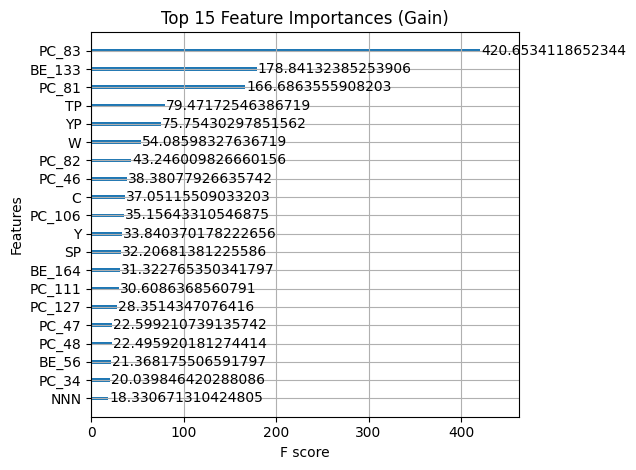

In [10]:
xgb.plot_importance(model, importance_type='gain', max_num_features=20)
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

# Feature Importance Analysis for Phosphorylation Site Prediction

## Top Features Summary

The XGBoost model identified several key features that strongly influence phosphorylation site prediction. Here's an interpretation of the most significant features:

### Physicochemical Properties (PC)
- **PC_83 (420.65)**: Overwhelmingly the most important feature, suggesting this particular physicochemical property has exceptional predictive power. This could represent an important aspect of amino acid interaction or structural characteristic that facilitates phosphorylation.
- **PC_81 (166.69) and PC_82 (43.25)**: Their high importance and sequential numbering suggests a specific group of related physicochemical properties that strongly influence phosphorylation.
- Other significant PC features (PC_46, PC_106, PC_111, etc.) indicate that various physicochemical properties play critical roles in determining phosphorylation sites.

### Binary Encoding Features (BE)
- **BE_133 (178.84)**: The second most important feature overall, suggesting that the presence/absence of specific amino acids at particular positions relative to the phosphorylation site is highly predictive.
- **BE_164, BE_56, BE_72, BE_196, BE_10**: These binary encoding features capture position-specific information about the sequence context around potential phosphorylation sites.

### Amino Acid Compositions
- **Dipeptides TP (79.47) and YP (75.75)**: The high importance of these dipeptides indicates that the presence of threonine-proline (TP) and tyrosine-proline (YP) sequences are strong indicators of phosphorylation sites. This aligns with biological knowledge, as proline-directed kinases often target S/T-P motifs.
- **Individual amino acids W (54.09), C (37.05), Y (33.84), S (14.86)**: Tryptophan (W) shows surprisingly high importance, while the phosphorylatable residues tyrosine (Y) and serine (S) are also significant. The importance of cysteine (C) may relate to its structural role through disulfide bonds.
- **SP (32.21)**: Serine-proline dipeptide, another proline-directed motif, is important as expected.
- **Tripeptide NNN (18.33) and dipeptide SVD (13.13)**: Specific sequence motifs that may be recognized by certain kinases.

## Biological Interpretation

1. **Proline-Directed Phosphorylation**: The high importance of TP, YP, and SP dipeptides confirms the biological knowledge that many kinases target sites followed by proline (proline-directed kinases like CDKs, MAPKs).

2. **Structural Determinants**: The dominance of physicochemical properties suggests that structural aspects (hydrophobicity, charge, flexibility) around the phosphorylation site are crucial for kinase recognition.

3. **Position-Specific Information**: The high ranking of multiple binary encoding features indicates that the precise positioning of amino acids around the phosphorylation site is critical for prediction.

4. **Amino Acid Preferences**: The importance of certain amino acids (W, C, Y, S, D, R, K) highlights specific preferences that may enhance kinase binding or create favorable structural environments for phosphorylation.